# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [52]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, count, col, desc, from_unixtime,\
floor, isnan, lag, lit, month, months_between, min, max, split, sum, udf, when, year
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from datetime import datetime

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [109]:
df = spark.read.json("mini_sparkify_event_data.json")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [110]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [111]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

### Investigate timestamps

In [112]:
df.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810483...|
| stddev|1.5075439608226302E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [114]:
ts = int(1538352117000)
ts /= 1000
print("Start Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

ts = int(1543799476000)
ts /= 1000
print("End Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

Start Time: 2018-10-01 00:01:57
End Time: 2018-12-03 01:11:16


### Investigate pages

In [115]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [116]:
df.filter(df.page=="Cancel").show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|   Adriel|     M|          103| Mendoza|  null| paid|  Kansas City, MO-KS|   PUT|Cancel|1535623466000|      514|null|   307|1538943740000|"Mozilla/5.0 (Mac...|    18|
|  null|Logged In|    Diego|     M|           55|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   PUT|Cancel|1537167593000|      540|null|   307|1539033031000|"Mozilla/5.0 (iPh...|    32|
|  null|Logged In|    Mason|     M|            9|    Hart|  null| free|  Co

In [117]:
df.filter(df.page=="Submit Downgrade").show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           47|   Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Calvin|     M|           17|Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38|
|  null|Logged In|  Kayle

In [118]:
df.filter(df.page=="Cancellation Confirmation").show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [119]:
# both free and premium have adverts
df.filter(df.page=="Roll Advert").show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|       page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|     M|          119|    Long|  null| free|Boston-Cambridge-...|   GET|Roll Advert|1538331630000|        8|null|   200|1538358779000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|     M|          127| 

In [120]:
df.filter(df.page=="Save Settings").show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|         page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|   Oliver|     M|           19| Gilbert|  null| paid|Philadelphia-Camd...|   PUT|Save Settings|1535093367000|      225|null|   307|1538415777000|"Mozilla/5.0 (Mac...|    81|
|  null|Logged In|  Spencer|     M|           53|Gonzalez|  null| free|         Concord, NH|   PUT|Save Settings|1537347211000|       64|null|   307|1538427008000|Mozilla/5.0 (X11;...|    65|
|  null|Logged In|     Lina|     F|     

In [121]:
df.filter(df.page=="NextSong").show(4)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [122]:
df.filter(df.page=="Add to Playlist").show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|  Ashlynn|     F|           15|Williams|  null| free|     Tallahassee, FL|   PUT|Add to Playlist|1537365219000|      217|null|   200|1538356816000|"Mozilla/5.0 (Mac...|    74|
|  null|Logged In|    Micah|  

In [123]:
df.filter(df.page=="Add Friend").show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|      page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Alex|     M|           14|   Hogan|  null| free|Denver-Aurora-Lak...|   PUT|Add Friend|1535066380000|      100|null|   307|1538361194000|Mozilla/5.0 (Wind...|   101|
|  null|Logged In|  Madison|     F|            6| Morales|  null| paid|Tampa-St. Petersb...|   PUT|Add Friend|1536287099000|      222|null|   307|1538370014000|"Mozilla/5.0 (Mac...|    25|
|  null|Logged In|  Madison|     F|           69| Moral

### Investigate timestamps

In [124]:
# check NaN values per column
# taken from: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [125]:
# check null values per column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [126]:
df.filter(col("firstName").isNull()).show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [127]:
df.filter((col("firstName").isNull()) & (col("gender").isNotNull())).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [128]:
df.filter((col("firstName").isNull()) & (col("lastName").isNotNull())).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



Entries with missing firstName are also missing gender, lastName, location, registration, userAgent

In [129]:
df.filter(col("firstName").isNull()).select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [130]:
# entries with missing firstname but with paid level are logging out
df.filter((col("firstName").isNull()) & (col("level")=="paid")).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|           49|    null|  null| paid|    null|   GET| Home|        null|      141|null|   200|1538381499000|     null|      |
|  null|Logged Out|     null|  null|           50|    null|  null| paid|    null|   PUT|Login|        null|      141|null|   307|1538381500000|     null|      |
|  null|Logged Out|     null|  null|           57|    null|  null| paid|    null|   GET| Home|        null|      141|null|   200|1538382349000|     null|      |
|  null|Logged Out|     null|  nul

We can just discard the data with missing firstName, lastName.

### Data preprocessing

In [131]:
# filter out all entries with missing names.
# they are not recording information that we will need for the model
df = df.filter(df.firstName.isNotNull())

In [132]:
# check null values
# ensure gender has no null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [133]:
# original timestamp in milliseconds, so divide by 1000
adjust_timestamp = udf(lambda x : x//1000, IntegerType())
df = df.withColumn("ts_adj", adjust_timestamp('ts'))

# convert adjusted timestamp to datetime
df = df.withColumn("datetime", from_unixtime(col("ts_adj")))
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|    ts_adj|           datetime|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|1538352117|2018-10-01 00:01:57|
|Five Iron F

In [134]:
# convert registration timestamp to datetime
df = df.withColumn("reg_adj", adjust_timestamp('registration'))
#df.show(5)
# convert adjusted registration timestamp to datetime
df = df.withColumn("reg_datetime", from_unixtime(col("reg_adj")))
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+----------+-------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|    ts_adj|           datetime|   reg_adj|       reg_datetime|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+----------+-------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|

In [135]:
# drop all the timestamp columns. Will not need them
columns_to_drop = ['registration', 'ts', 'ts_adj', 'reg_adj']
df = df.drop(*columns_to_drop)

In [136]:
# to extract month example
df.select(month('datetime').alias('month')).show(5)

+-----+
|month|
+-----+
|   10|
|   10|
|   10|
|   10|
|   10|
+-----+
only showing top 5 rows



In [137]:
# to extract year example
df.select(year('datetime').alias('month')).show(5)

+-----+
|month|
+-----+
| 2018|
| 2018|
| 2018|
| 2018|
| 2018|
+-----+
only showing top 5 rows



In [138]:
df.select(months_between(df.datetime, df.reg_datetime).alias('months')).show(5)

+----------+
|    months|
+----------+
|0.09899754|
|0.03993056|
|0.09910096|
|0.04001867|
|0.09920624|
+----------+
only showing top 5 rows



In [139]:
# add start date of analysis
df = df.withColumn('analysis_start_date', lit('2018-10-01 00:00:00'))

In [140]:
# number the months starting from the very first month of the analysis
df = df.withColumn("month_num", floor(months_between(df.datetime, df.analysis_start_date)))

In [141]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+---------+------+--------------------+------+-------------------+-------------------+-------------------+---------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|sessionId|     song|status|           userAgent|userId|           datetime|       reg_datetime|analysis_start_date|month_num|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+---------+------+--------------------+------+-------------------+-------------------+-------------------+---------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|       29|Rockpools|   200|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|2018-09-28 22:22:42|2018-10-01 00:00:00|        0|
|Five Iron F

In [142]:
# engineer free or paid binary variable
# free: 0, paid: 1
df = df.replace(["free", "paid"], ["0", "1"], "level")

# engineer male and female binary binary variable
# male: 0, female: 1
df = df.replace(["M", "F"], ["0", "1"], "gender")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [143]:
# can possibly switch to a 2-class classification system
def define_churn(x):
    """
    Defining churn as cancellation of service or downgrading from premium to free tier.
    """
    if x == "Cancellation Confirmation":
        return 1
    elif x == "Submit Downgrade":
        return 1
    else:
        return 0
    
churn_event = udf(lambda x : define_churn(x), IntegerType())
    
df = df.withColumn("churn", churn_event("page"))

In [144]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+---------+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|sessionId|     song|status|           userAgent|userId|           datetime|       reg_datetime|analysis_start_date|month_num|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+---------+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|  Martha Tilston|Logged In|    Colin|     0|           50| Freeman|277.89016|    1|     Bakersfield, CA|   PUT|NextSong|       29|Rockpools|   200|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|2018-09-28 22:22:42|2018-10-01 00:00:00|     

In [145]:
df.select('month_num','churn').groupBy('month_num','churn').count().orderBy('month_num', 'churn').show()

+---------+-----+------+
|month_num|churn| count|
+---------+-----+------+
|        0|    0|144848|
|        0|    1|    68|
|        1|    0|133187|
|        1|    1|    47|
|        2|    0|     4|
+---------+-----+------+



In [146]:
# aggregate number of page visits for each user on a monthly basis

df_register = df.select('userId', 'month_num', 'page') \
.where(df.page=="Register") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numRegister')

df_cancel = df.select('userId', 'month_num', 'page') \
.where(df.page=="Cancel") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numCancelVisits')

df_upgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Upgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numUpgradeVisits')

df_downgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Downgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numDowngradeVisits')

df_home = df.select('userId', 'month_num', 'page') \
.where(df.page=="Home") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numHomeVisits')

df_about = df.select('userId', 'month_num', 'page') \
.where(df.page=="About") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAboutVisits')

df_settings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSettingsVisits')

df_saveSettings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Save Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSaveSettings')

df_login = df.select('userId', 'month_num', 'page') \
.where(df.page=="Login") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogins')

df_logout = df.select('userId', 'month_num', 'page') \
.where(df.page=="Logout") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogouts')

df_addPlaylist = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add to Playlist") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAddPlaylists')

df_addFriend = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add Friend") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numFriends')

df_thumbsUp = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Up") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsUp')

df_thumbsDown = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Down") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsDown')

df_advert = df.select('userId', 'month_num', 'page') \
.where(df.page=="Roll Advert") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAdverts')

df_songsPlayed = df.select('userId', 'month_num', 'page') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSongsPlayed')

df_totalListen = df.select('userId', 'month_num', 'length') \
.groupBy('userId', 'month_num') \
.agg({'length':'sum'}) \
.withColumnRenamed('sum(length)', 'totalListenTime')

# if user had premium at any point of the month, assumer he/she has premium for
# the whole month for simplicity
df_level = df.select('userId', 'month_num', 'level') \
.groupBy('userId', 'month_num') \
.agg({'level':'max'}) \
.withColumnRenamed('max(level)', 'level')

# assuming nobody changes gender midway
df_gender = df.select('userId', 'month_num', 'gender') \
.groupBy('userId', 'month_num') \
.agg({'gender':'max'}) \
.withColumnRenamed('max(gender)', 'gender')

df_churn = df.select('userId', 'month_num', 'churn') \
.groupBy('userId', 'month_num') \
.agg({'churn':'max'}) \
.withColumnRenamed('max(churn)', 'churn')

In [147]:
all_data = df_register.join(df_cancel, ['userId', 'month_num'], 'outer') \
.join(df_upgrade, ['userId', 'month_num'], 'outer') \
.join(df_downgrade, ['userId', 'month_num'], 'outer') \
.join(df_home, ['userId', 'month_num'], 'outer') \
.join(df_about, ['userId', 'month_num'], 'outer') \
.join(df_settings, ['userId', 'month_num'], 'outer') \
.join(df_saveSettings, ['userId', 'month_num'], 'outer') \
.join(df_login, ['userId', 'month_num'], 'outer') \
.join(df_logout, ['userId', 'month_num'], 'outer') \
.join(df_addPlaylist, ['userId', 'month_num'], 'outer') \
.join(df_addFriend, ['userId', 'month_num'], 'outer') \
.join(df_thumbsUp, ['userId', 'month_num'], 'outer') \
.join(df_thumbsDown, ['userId', 'month_num'], 'outer') \
.join(df_advert, ['userId', 'month_num'], 'outer') \
.join(df_songsPlayed, ['userId', 'month_num'], 'outer') \
.join(df_totalListen, ['userId', 'month_num'], 'outer') \
.join(df_level, ['userId', 'month_num'], 'outer') \
.join(df_gender, ['userId', 'month_num'], 'outer') \
.join(df_churn, ['userId', 'month_num'], 'outer')

In [148]:
all_data.show(5)

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+-----+------+-----+
|userId|month_num|numRegister|numCancelVisits|numUpgradeVisits|numDowngradeVisits|numHomeVisits|numAboutVisits|numSettingsVisits|numSaveSettings|numLogins|numLogouts|numAddPlaylists|numFriends|numThumbsUp|numThumbsDown|numAdverts|numSongsPlayed|   totalListenTime|level|gender|churn|
+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+-----+------+-----+
|   149|        0|       null|           null|               1|              null|            7|          null|                3|           null|   

In [149]:
windowlag = (Window.partitionBy('userId').orderBy('month_num'))

# generate 1 month lag features
all_data = all_data.withColumn('numRegister_lastMonth', lag(all_data['numRegister']).over(windowlag))
all_data = all_data.withColumn('numCancelVisits_lastMonth', lag(all_data['numCancelVisits']).over(windowlag))
all_data = all_data.withColumn('numUpgradeVisits_lastMonth', lag(all_data['numUpgradeVisits']).over(windowlag))
all_data = all_data.withColumn('numDowngradeVisits_lastMonth', lag(all_data['numDowngradeVisits']).over(windowlag))
all_data = all_data.withColumn('numHomeVisits_lastMonth', lag(all_data['numHomeVisits']).over(windowlag))
all_data = all_data.withColumn('numAboutVisits_lastMonth', lag(all_data['numAboutVisits']).over(windowlag))
all_data = all_data.withColumn('numSettingsVisits_lastMonth', lag(all_data['numSettingsVisits']).over(windowlag))
all_data = all_data.withColumn('numSaveSettings_lastMonth', lag(all_data['numSaveSettings']).over(windowlag))
all_data = all_data.withColumn('numLogins_lastMonth', lag(all_data['numLogins']).over(windowlag))
all_data = all_data.withColumn('numLogouts_lastMonth', lag(all_data['numLogouts']).over(windowlag))
all_data = all_data.withColumn('numAddPlaylists_lastMonth', lag(all_data['numAddPlaylists']).over(windowlag))
all_data = all_data.withColumn('numFriends_lastMonth', lag(all_data['numFriends']).over(windowlag))
all_data = all_data.withColumn('numThumbsUp_lastMonth', lag(all_data['numThumbsUp']).over(windowlag))
all_data = all_data.withColumn('numThumbsDown_lastMonth', lag(all_data['numThumbsDown']).over(windowlag))
all_data = all_data.withColumn('numAdverts_lastMonth', lag(all_data['numAdverts']).over(windowlag))
all_data = all_data.withColumn('numSongsPlayed_lastMonth', lag(all_data['numSongsPlayed']).over(windowlag))
all_data = all_data.withColumn('totalListenTime_lastMonth', lag(all_data['totalListenTime']).over(windowlag))
all_data = all_data.withColumn('level_lastMonth', lag(all_data['level']).over(windowlag))

In [150]:
# check one individual
all_data.filter(all_data.userId=="55").show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+-----+------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+---------------+
|userId|month_num|numRegister|numCancelVisits|numUpgradeVisits|numDowngradeVisits|numHomeVisits|numAboutVisits|numSettingsVisits|numSaveSettings|numLogins|numLogouts|numAddPlaylists|numFriends|numThumbsUp|numThumbsDown|numAdverts|numSongsPlayed|   totalListenTime|level|gender|churn|numR

In [151]:
windowMov = (Window.partitionBy('userId').orderBy('month_num')
             .rangeBetween(Window.unboundedPreceding, 0))

# generate moving averages from previous months, not including current mmonth.
# For small dataset, it will be the same as the 1 month lag values
# since there are only 2 months. For the full dataset, there may be more than 2 months, 
# so moving averages will be different from 1 month lag
all_data = all_data.withColumn('numRegister_cum_old', sum('numRegister').over(windowMov))
all_data = all_data.withColumn('numRegister_cum',\
                               (all_data['numRegister_cum_old'] - all_data['numRegister']))
all_data = all_data.withColumn('numRegister_movAvg',\
                               (all_data['numRegister_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numCancelVisits_cum_old', sum('numCancelVisits').over(windowMov))
all_data = all_data.withColumn('numCancelVisits_cum',\
                               (all_data['numCancelVisits_cum_old'] - all_data['numCancelVisits']))
all_data = all_data.withColumn('numCancelVisits_movAvg',\
                               (all_data['numCancelVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numUpgradeVisits_cum_old', sum('numUpgradeVisits').over(windowMov))
all_data = all_data.withColumn('numUpgradeVisits_cum',\
                               (all_data['numUpgradeVisits_cum_old'] - all_data['numUpgradeVisits']))
all_data = all_data.withColumn('numUpgradeVisits_movAvg',\
                               (all_data['numUpgradeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numDowngradeVisits_cum_old', sum('numDowngradeVisits').over(windowMov))
all_data = all_data.withColumn('numDowngradeVisits_cum',\
                               (all_data['numDowngradeVisits_cum_old'] - all_data['numDowngradeVisits']))
all_data = all_data.withColumn('numDowngradeVisits_movAvg',\
                               (all_data['numDowngradeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numHomeVisits_cum_old', sum('numHomeVisits').over(windowMov))
all_data = all_data.withColumn('numHomeVisits_cum',\
                               (all_data['numHomeVisits_cum_old'] - all_data['numHomeVisits']))
all_data = all_data.withColumn('numHomeVisits_movAvg',\
                               (all_data['numHomeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAboutVisits_cum_old', sum('numAboutVisits').over(windowMov))
all_data = all_data.withColumn('numAboutVisits_cum',\
                               (all_data['numAboutVisits_cum_old'] - all_data['numAboutVisits']))
all_data = all_data.withColumn('numAboutVisits_movAvg',\
                               (all_data['numAboutVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSettingsVisits_cum_old', sum('numSettingsVisits').over(windowMov))
all_data = all_data.withColumn('numSettingsVisits_cum',\
                               (all_data['numSettingsVisits_cum_old'] - all_data['numSettingsVisits']))
all_data = all_data.withColumn('numSettingsVisits_movAvg',\
                               (all_data['numSettingsVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSaveSettings_cum_old', sum('numSaveSettings').over(windowMov))
all_data = all_data.withColumn('numSaveSettings_cum',\
                               (all_data['numSaveSettings_cum_old'] - all_data['numSaveSettings']))
all_data = all_data.withColumn('numSaveSettings_movAvg',\
                               (all_data['numSaveSettings_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numLogins_cum_old', sum('numLogins').over(windowMov))
all_data = all_data.withColumn('numLogins_cum',\
                               (all_data['numLogins_cum_old'] - all_data['numLogins']))
all_data = all_data.withColumn('numLogins_movAvg',\
                               (all_data['numLogins_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numLogouts_cum_old', sum('numLogouts').over(windowMov))
all_data = all_data.withColumn('numLogouts_cum',\
                               (all_data['numLogouts_cum_old'] - all_data['numLogouts']))
all_data = all_data.withColumn('numLogouts_movAvg',\
                               (all_data['numLogouts_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAddPlaylists_cum_old', sum('numAddPlaylists').over(windowMov))
all_data = all_data.withColumn('numAddPlaylists_cum',\
                               (all_data['numAddPlaylists_cum_old'] - all_data['numAddPlaylists']))
all_data = all_data.withColumn('numAddPlaylists_movAvg',\
                               (all_data['numAddPlaylists_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numFriends_cum_old', sum('numFriends').over(windowMov))
all_data = all_data.withColumn('numFriends_cum',\
                               (all_data['numFriends_cum_old'] - all_data['numFriends']))
all_data = all_data.withColumn('numFriends_movAvg',\
                               (all_data['numFriends_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numThumbsUp_cum_old', sum('numThumbsUp').over(windowMov))
all_data = all_data.withColumn('numThumbsUp_cum',\
                               (all_data['numThumbsUp_cum_old'] - all_data['numThumbsUp']))
all_data = all_data.withColumn('numThumbsUp_movAvg',\
                               (all_data['numThumbsUp_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numThumbsDown_cum_old', sum('numThumbsDown').over(windowMov))
all_data = all_data.withColumn('numThumbsDown_cum',\
                               (all_data['numThumbsDown_cum_old'] - all_data['numThumbsDown']))
all_data = all_data.withColumn('numThumbsDown_movAvg',\
                               (all_data['numThumbsDown_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAdverts_cum_old', sum('numAdverts').over(windowMov))
all_data = all_data.withColumn('numAdverts_cum',\
                               (all_data['numAdverts_cum_old'] - all_data['numAdverts']))
all_data = all_data.withColumn('numAdverts_movAvg',\
                               (all_data['numAdverts_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSongsPlayed_cum_old', sum('numSongsPlayed').over(windowMov))
all_data = all_data.withColumn('numSongsPlayed_cum',\
                               (all_data['numSongsPlayed_cum_old'] - all_data['numSongsPlayed']))
all_data = all_data.withColumn('numSongsPlayed_movAvg',\
                               (all_data['numSongsPlayed_cum'] / all_data['month_num']))

all_data = all_data.withColumn('totalListenTime_cum_old', sum('totalListenTime').over(windowMov))
all_data = all_data.withColumn('totalListenTime_cum',\
                               (all_data['totalListenTime_cum_old'] - all_data['totalListenTime']))
all_data = all_data.withColumn('totalListenTime_movAvg',\
                               (all_data['totalListenTime_cum'] / all_data['month_num']))

In [152]:
all_data.filter(all_data.userId=="55").show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+-----+------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+---------------+-------------------+---------------+------------------+-----------------------+-------------------+----------------------+------------------------+--------------------+-----------------------+--------------------------+----------------------+-------------------------+--------------------

In [153]:
# fill na/null values with 0
all_data = all_data.na.fill(0)

# alternatively, can do this
# df = df.fillna({'col':'4'})

all_data.select([count(when(col(c).isNull(), c)).alias(c) for c in all_data.columns]).show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+---------------+-----+------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+---------------+-------------------+---------------+------------------+-----------------------+-------------------+----------------------+------------------------+--------------------+-----------------------+--------------------------+----------------------+-------------------------+---------------------+-

In [154]:
# visualize 1 month lag values
all_data_pd = all_data \
.filter(all_data.month_num>=1) \
.select('numRegister_lastMonth','numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth',\
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'level_lastMonth', 'gender', 'churn'
        ).toPandas()

In [155]:
all_data_pd.head()

,numRegister_lastMonth,numCancelVisits_lastMonth,numUpgradeVisits_lastMonth,numDowngradeVisits_lastMonth,numHomeVisits_lastMonth,numAboutVisits_lastMonth,numSettingsVisits_lastMonth,numSaveSettings_lastMonth,numLogins_lastMonth,numLogouts_lastMonth,numAddPlaylists_lastMonth,numFriends_lastMonth,numThumbsUp_lastMonth,numThumbsDown_lastMonth,numAdverts_lastMonth,numSongsPlayed_lastMonth,totalListenTime_lastMonth,level_lastMonth,gender,churn
0,0,0,1,0,6,0,0,0,0,2,2,3,6,1,22,120,28266.62965,0,1,0
1,0,0,2,3,14,2,3,0,0,3,6,4,15,6,7,267,64662.97119,1,0,0
2,0,0,0,24,105,2,9,3,0,37,73,37,86,18,4,2204,547278.07597,1,1,0
3,0,0,2,0,6,0,2,0,0,1,3,1,4,1,13,109,27828.06488,0,0,0
4,0,0,0,16,58,1,12,1,0,19,30,17,47,8,0,1117,279580.62019,1,0,0


In [156]:
all_data_pd[all_data_pd['numCancelVisits_lastMonth']>0].head()

,numRegister_lastMonth,numCancelVisits_lastMonth,numUpgradeVisits_lastMonth,numDowngradeVisits_lastMonth,numHomeVisits_lastMonth,numAboutVisits_lastMonth,numSettingsVisits_lastMonth,numSaveSettings_lastMonth,numLogins_lastMonth,numLogouts_lastMonth,numAddPlaylists_lastMonth,numFriends_lastMonth,numThumbsUp_lastMonth,numThumbsDown_lastMonth,numAdverts_lastMonth,numSongsPlayed_lastMonth,totalListenTime_lastMonth,level_lastMonth,gender,churn


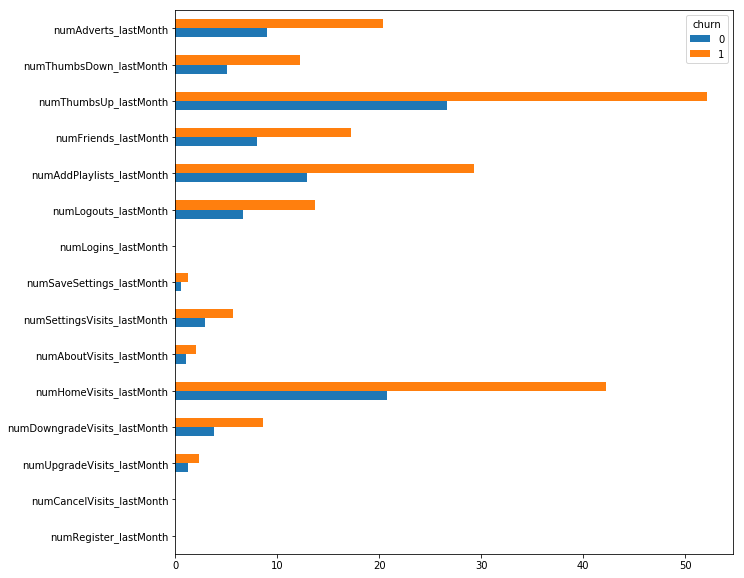

In [157]:
all_data_pd.groupby('churn').agg({'numRegister_lastMonth':'mean',\
                                  'numCancelVisits_lastMonth':'mean',\
                                  'numUpgradeVisits_lastMonth':'mean',\
                                  'numDowngradeVisits_lastMonth':'mean',\
                                  'numHomeVisits_lastMonth':'mean',\
                                  'numAboutVisits_lastMonth':'mean',\
                                  'numSettingsVisits_lastMonth':'mean',\
                                  'numSaveSettings_lastMonth':'mean',\
                                  'numLogins_lastMonth':'mean',\
                                  'numLogouts_lastMonth':'mean',\
                                  'numAddPlaylists_lastMonth':'mean',\
                                  'numFriends_lastMonth':'mean',\
                                  'numThumbsUp_lastMonth':'mean',\
                                  'numThumbsDown_lastMonth':'mean',\
                                  'numAdverts_lastMonth':'mean'
                                  #'numSongsPlayed_lastMonth':'mean'
                                  #'totalListenTime_lastMonth':'mean'
                                 }).T.plot.barh(figsize=(10,10));

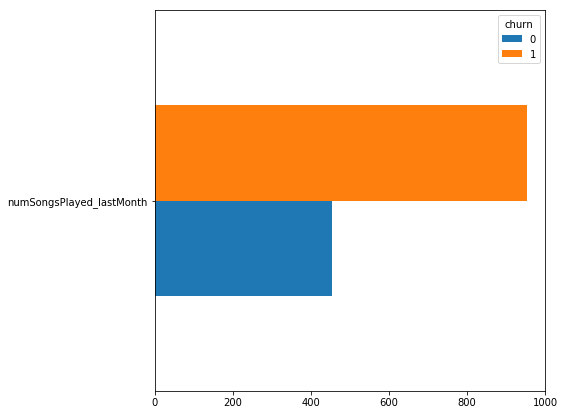

In [158]:
all_data_pd.groupby('churn').agg({'numSongsPlayed_lastMonth':'mean'}).T.plot.barh(figsize=(7,7));

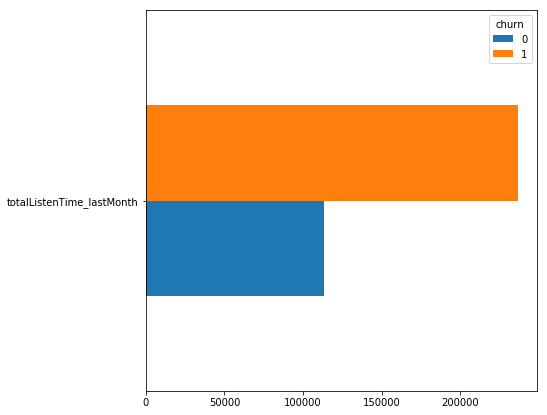

In [159]:
all_data_pd.groupby('churn').agg({'totalListenTime_lastMonth':'mean'}).T.plot.barh(figsize=(7,7));

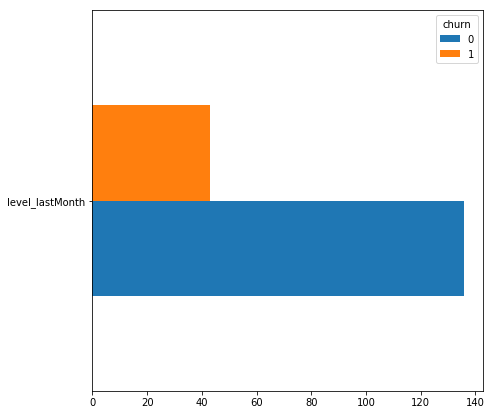

In [160]:
#all_data_pd.groupby('churn').agg({'level_lastMonth':'count'}).T.plot.barh(figsize=(7,7));

In [162]:
#all_data_pd.groupby('churn').agg({'gender':'count'})

,gender
churn,
0,148
1,43


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.